In [1]:
import scanpy as sc
import anndata as ad
import episcanpy.api as epi
import numpy as np
from scipy import stats
import pandas as pd
import os
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics.cluster import homogeneity_score

sc.settings.set_figure_params(dpi=80, color_map='gist_earth')

def getNClusters(adata,n_cluster,range_min=0,range_max=3,max_steps=20):
    this_step = 0
    this_min = float(range_min)
    this_max = float(range_max)
    while this_step < max_steps:
        print('step ' + str(this_step))
        this_resolution = this_min + ((this_max-this_min)/2)
        sc.tl.louvain(adata,resolution=this_resolution)
        this_clusters = adata.obs['louvain'].nunique()
        
        print('got ' + str(this_clusters) + ' at resolution ' + str(this_resolution))
        
        if this_clusters > n_cluster:
            this_max = this_resolution
        elif this_clusters < n_cluster:
            this_min = this_resolution
        else:
            return(this_resolution, adata)
        this_step += 1
    
    print('Cannot find the number of clusters')
    print('Clustering solution from last iteration is used:' + str(this_clusters) + ' at resolution ' + str(this_resolution))
    
nb_features = 100000

/Users/annadanese/anaconda3/lib/python3.8/site-packages/scanpy/api/__init__.py:3: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  warnings.warn(


# Load the processed data

In [110]:
adata = ad.read('epiScanpy_10xpbmc5k.h5ad')
adata

## Metrics

In [111]:
metadata = pd.read_csv('../input/metadata.tsv',sep='\t',index_col=0)
num_clusters = len(np.unique(metadata['label cell_type']))
print(num_clusters)

8


In [112]:
getNClusters(adata, n_cluster=num_clusters)

step 0
got 18 at resolution 1.5
step 1
got 12 at resolution 0.75
step 2
got 10 at resolution 0.375
step 3
got 6 at resolution 0.1875
step 4
got 7 at resolution 0.28125
step 5
got 9 at resolution 0.328125
step 6
got 8 at resolution 0.3046875


(0.3046875,
 AnnData object with n_obs × n_vars = 4645 × 138516
     obs: 'nb_features', 'log_nb_features', 'n_counts', 'louvain'
     var: 'batch', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
     uns: 'pca', 'neighbors', 'umap', 'log1p', 'louvain', 'louvain_colors'
     obsm: 'X_pca', 'X_tsne', 'X_umap'
     varm: 'PCs'
     obsp: 'distances', 'connectivities')

In [113]:
kmeans = KMeans(n_clusters=num_clusters, random_state=2019).fit(adata.X)
adata.obs['kmeans'] = pd.Series(kmeans.labels_,index=adata.obs.index).astype('category')

In [118]:
#hierachical clustering
adata.X = adata.X.todense()
hc = AgglomerativeClustering(n_clusters=num_clusters).fit(adata.X)
adata.obs['hc'] = pd.Series(hc.labels_,index=adata.obs.index).astype('category')

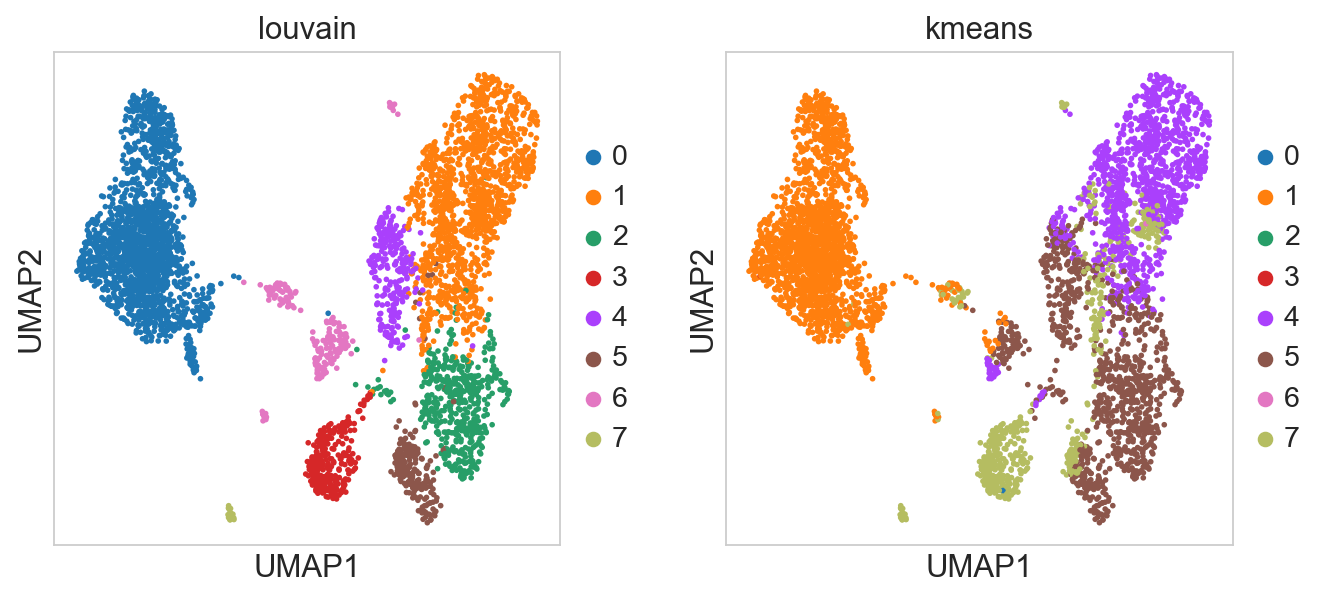

In [114]:
sc.pl.umap(adata, color=['louvain', 'kmeans', 'hc'])
#sc.pl.umap(adata, color=['louvain', 'kmeans'])

In [115]:
path_clusters = '../clusters/'
method = 'episcanpy'
adata.obs[['louvain','kmeans','hc']].to_csv(os.path.join(path_clusters ,method + '_clusters.tsv'),sep='\t')

## Plot the metrics

In [2]:
def residual_average_gini_index(gene_scores,folder_clusters,
                                housekeeping_genes,marker_genes,
                                min_cells_per_cluster=10):

    #Subset from the main matrix the housekeeping genes and marker genes
    df_matrix_housekeeping=gene_scores.loc[gene_scores.index.intersection(housekeeping_genes),]
    df_matrix_marker=gene_scores.loc[gene_scores.index.intersection(marker_genes),]
    
    #Define a function to compute the Gini score
    def gini(list_of_values):
        sorted_list = sorted(list_of_values)
        height, area = 0, 0
        for value in sorted_list:
            height += value
            area += height - value / 2.
            fair_area = height * len(list_of_values) / 2.
        return (fair_area - area) / fair_area
    
    #Function to calculate Gini value for all the genes
    def calculate_gini(df_matrix, gene_name,clustering_info):
        return gini(get_avg_per_cluster(df_matrix,gene_name,clustering_info,use_log2=False))

    #Function to calculate Gini value for all the genes
    def calculate_gini_values(df_matrix,clustering_info):
        gini_values=[]
        for gene_name in df_matrix.index:
            gini_values.append(calculate_gini(df_matrix, gene_name,clustering_info))
        return gini_values
    
    #Write a function to compute delta difference of the average accessibility in Marker vs Housekeeping and Kolmogorov Smirnov test
    def score_clustering_solution(df_matrix_marker,df_matrix_housekeeping,clustering_info):
        gini_values_housekeeping=calculate_gini_values(df_matrix_housekeeping,clustering_info)
        gini_values_marker=calculate_gini_values(df_matrix_marker,clustering_info)
        statistic,p_value=stats.ks_2samp(gini_values_marker,gini_values_housekeeping)
        
        return  np.mean(gini_values_marker), np.mean(gini_values_housekeeping),np.mean(gini_values_marker)-np.mean(gini_values_housekeeping), statistic,p_value

    #Function to compute the average accessibility value per cluster
    def get_avg_per_cluster(df_matrix, gene_name, clustering_info,use_log2=False):
        N_clusters=len(clustering_info.index.unique())
        avg_per_cluster=np.zeros(N_clusters)
        for idx,idx_cluster in enumerate(sorted(np.unique(clustering_info.index.unique()))):
            if use_log2:
                values_cluster=df_matrix.loc[gene_name,clustering_info.loc[idx_cluster,:].values.flatten()].apply(lambda x:np.log2(x+1))
            else:
                values_cluster=df_matrix.loc[gene_name,clustering_info.loc[idx_cluster,:].values.flatten()]
           
            avg_per_cluster[idx]=values_cluster.mean()
            if avg_per_cluster[idx]>0:
                  avg_per_cluster[idx]=avg_per_cluster[idx]#/values_cluster.std()

        return avg_per_cluster
    

    #Run the method for all the clustering solutions
    
    df_metrics = pd.DataFrame(columns=['Method','Clustering','Gini_Marker_Genes','Gini_Housekeeping_Genes','Difference','KS_statistics','p-value'])    
    
    for clusters_filename in os.listdir(folder_clusters):     
        method = '_'.join(clusters_filename.split('_')[:-1])
        print(method)
        df_clusters = pd.read_csv(os.path.join(folder_clusters,clusters_filename),sep='\t',index_col=0)
        for clustering_method in df_clusters.columns:
            clustering_info = pd.DataFrame(df_clusters[clustering_method])
            clustering_info['Barcode'] = clustering_info.index
            clustering_info=clustering_info.set_index(clustering_method)
            
            #REMOVE CLUSTERS WITH FEW CELLS
            cluster_sizes=pd.value_counts(clustering_info.index)
            clustering_info=clustering_info.loc[cluster_sizes[cluster_sizes>min_cells_per_cluster].index.values,:]


            mean_gini_marker,mean_gini_housekeeping,mean_gini_difference,statistics,p_value=score_clustering_solution(df_matrix_marker,df_matrix_housekeeping,clustering_info)

            df_metrics = df_metrics.append({'Method': method,'Clustering':clustering_method,
                               'Gini_Marker_Genes':mean_gini_marker,'Gini_Housekeeping_Genes':mean_gini_housekeeping,
                               'Difference':mean_gini_difference,'KS_statistics':statistics,'p-value':p_value},
                              ignore_index=True)  
        
    return df_metrics


gene_scores = pd.read_csv('../input/FM_GeneScoring_10xpbmc5k.tsv',
                         sep = '\t',index_col=0)

#https://www.tau.ac.il/~elieis/Housekeeping_genes.html List of Housekeeping genes
housekeeping_genes=['ACTB','ALDOA','GAPDH','PGK1','LDHA','RPS27A','RPL19','RPL11','NONO','ARHGDIA','RPL32','RPS18','HSPCB',
    'C1orf43','CHMP2A','EMC7','GPI','PSMB2,''PSMB4','RAB7A','REEP5','SNRPD3','VCP','VPS29']

#List of Marker Genes
marker_genes=['CD209', 'ENG', 'FOXP3', 'CD34', 'BATF3', 'S100A12', 'THBD','CD3D', 'THY1', 'CD8A', 'CD8B', 'CD14', 'PROM1', 'IL2RA', 'FCGR3A',
'IL3RA', 'FCGR1A', 'CD19', 'IL7R', 'CD79A', 'MS4A1', 'NCAM1','CD3E', 'CD3G', 'KIT', 'CD1C', 'CD68', 'CD4']

all_metrics = """0	ChromVAR_motifs	louvain	0.329794	0.202917	0.126878	0.535714	0.001101
1	ChromVAR_motifs	kmeans	0.343745	0.237399	0.106345	0.464286	0.007129
2	ChromVAR_motifs	hc	0.381168	0.290041	0.091127	0.500000	0.002897
3	ChromVAR_kmers	louvain	0.309164	0.178850	0.130315	0.535714	0.001101
4	ChromVAR_kmers	kmeans	0.340088	0.263170	0.076918	0.488095	0.003940
5	ChromVAR_kmers	hc	0.319202	0.241089	0.078113	0.523810	0.001532
6	cisTopic	louvain	0.369119	0.254688	0.114431	0.571429	0.000392
7	cisTopic	kmeans	0.417319	0.316060	0.101259	0.500000	0.002897
8	cisTopic	hc	0.468534	0.362493	0.106041	0.500000	0.002897
9	SnapATAC	louvain	0.332478	0.195798	0.136680	0.452381	0.009484
10	SnapATAC	kmeans	0.361506	0.217868	0.143637	0.571429	0.000392
11	SnapATAC	hc	0.371438	0.231429	0.140009	0.523810	0.001532
12	BROCKMAN	louvain	0.346999	0.234125	0.112874	0.476190	0.005320
13	BROCKMAN	kmeans	0.327789	0.262820	0.064969	0.392857	0.035346
14	BROCKMAN	hc	0.324061	0.255878	0.068183	0.464286	0.007129
15	SCRAT_motifs	louvain	0.347878	0.293645	0.054233	0.476190	0.005320
16	SCRAT_motifs	kmeans	0.287355	0.234507	0.052848	0.392857	0.035346
17	SCRAT_motifs	hc	0.315229	0.263967	0.051262	0.416667	0.021353
18	Cusanovich2018	louvain	0.388897	0.280957	0.107940	0.464286	0.007129
19	Cusanovich2018	kmeans	0.254027	0.177305	0.076722	0.464286	0.007129
20	Cusanovich2018	hc	0.225468	0.141125	0.084343	0.464286	0.007129
21	Control	louvain	0.443971	0.358864	0.085107	0.464286	0.007129
22	Control	kmeans	0.456480	0.453863	0.002617	0.273810	0.280812
23	Control	hc	0.471765	0.467423	0.004342	0.238095	0.448886
24	GeneScoring	louvain	0.460154	0.389402	0.070752	0.428571	0.016413
25	GeneScoring	kmeans	0.450160	0.471894	-0.021734	0.297619	0.197109
26	GeneScoring	hc	0.503348	0.501473	0.001875	0.285714	0.236193
27	Scasat	louvain	0.472445	0.374599	0.097846	0.500000	0.002897
28	Scasat	kmeans	0.497129	0.421512	0.075617	0.428571	0.016413
29	Scasat	hc	0.477655	0.399098	0.078557	0.464286	0.007129
30	scABC	louvain	0.461698	0.441462	0.020237	0.297619	0.197109
31	scABC	kmeans	0.458673	0.454737	0.003937	0.238095	0.448886
32	scABC	hc	0.425721	0.396330	0.029391	0.321429	0.134155
33	Cicero	louvain	0.354993	0.249562	0.105431	0.547619	0.000786
34	Cicero	kmeans	0.000000	0.000000	0.000000	0.000000	1.000000
35	Cicero	hc	0.264151	0.203767	0.060383	0.357143	0.071204
36	ChromVAR_kmers_pca	louvain	0.352224	0.232139	0.120086	0.511905	0.002114
37	ChromVAR_kmers_pca	kmeans	0.287473	0.227681	0.059792	0.488095	0.003940
38	ChromVAR_kmers_pca	hc	0.322012	0.246821	0.075191	0.464286	0.007129
39	ChromVAR_motifs_pca	louvain	0.333697	0.205199	0.128498	0.535714	0.001101
40	ChromVAR_motifs_pca	kmeans	0.396433	0.301102	0.095331	0.428571	0.016413
41	ChromVAR_motifs_pca	hc	0.397484	0.301730	0.095755	0.440476	0.012522
42	GeneScoring_pca	louvain	0.517697	0.503202	0.014495	0.261905	0.331171
43	GeneScoring_pca	kmeans	0.488294	0.499929	-0.011635	0.333333	0.109433
44	GeneScoring_pca	hc	0.469333	0.473566	-0.004233	0.285714	0.236193
45	Cicero_pca	louvain	0.470227	0.356027	0.114200	0.488095	0.003940
46	Cicero_pca	kmeans	0.262221	0.197641	0.064580	0.357143	0.071204
47	Cicero_pca	hc	0.250496	0.172051	0.078446	0.464286	0.007129
48	SCRAT_pca	louvain	0.392071	0.320236	0.071835	0.464286	0.007129
49	SCRAT_pca	kmeans	0.287531	0.234164	0.053367	0.392857	0.035346
50	SCRAT_pca	hc	0.278123	0.232857	0.045266	0.404762	0.027574
"""

all_metrics = [line.split('\t') for line in  all_metrics.split('\n')[:-1]]
all_metrics2 = []
for line in all_metrics:
    line[3:] = [float(x) for x in line[3:]]
    all_metrics2.append(line) 
all_metrics2

titles = ["Method","Clustering","Gini_Marker_Genes",
          "Gini_Housekeeping_Genes","Difference","KS_statistics","p-value"]
df_metrics = pd.DataFrame([x[1:] for x in all_metrics], columns=np.array(titles))

folder_clusters='../clusters/'
df_metrics2 = residual_average_gini_index(gene_scores,folder_clusters,
                                housekeeping_genes,marker_genes,
                                min_cells_per_cluster=10)
df_metrics = pd.concat([df_metrics, df_metrics2])
df_metrics.sort_values(by=['Difference'], ascending=False)

episcanpy


,Method,Clustering,Gini_Marker_Genes,Gini_Housekeeping_Genes,Difference,KS_statistics,p-value
10,SnapATAC,kmeans,0.361506,0.217868,0.143637,0.571429,0.000392
11,SnapATAC,hc,0.371438,0.231429,0.140009,0.523810,0.001532
9,SnapATAC,louvain,0.332478,0.195798,0.136680,0.452381,0.009484
3,ChromVAR_kmers,louvain,0.309164,0.178850,0.130315,0.535714,0.001101
0,episcanpy,louvain,0.395500,0.265706,0.129794,0.511905,0.002292
39,ChromVAR_motifs_pca,louvain,0.333697,0.205199,0.128498,0.535714,0.001101
0,ChromVAR_motifs,louvain,0.329794,0.202917,0.126878,0.535714,0.001101
36,ChromVAR_kmers_pca,louvain,0.352224,0.232139,0.120086,0.511905,0.002114
6,cisTopic,louvain,0.369119,0.254688,0.114431,0.571429,0.000392
45,Cicero_pca,louvain,0.470227,0.356027,0.114200,0.488095,0.003940


In [3]:
is_louvain =  df_metrics['Clustering']=='louvain'
df_metrics = df_metrics[is_louvain]
df_metrics.sort_values(by=['Difference'], ascending=False)

,Method,Clustering,Gini_Marker_Genes,Gini_Housekeeping_Genes,Difference,KS_statistics,p-value
9,SnapATAC,louvain,0.332478,0.195798,0.136680,0.452381,0.009484
3,ChromVAR_kmers,louvain,0.309164,0.178850,0.130315,0.535714,0.001101
0,episcanpy,louvain,0.395500,0.265706,0.129794,0.511905,0.002292
39,ChromVAR_motifs_pca,louvain,0.333697,0.205199,0.128498,0.535714,0.001101
0,ChromVAR_motifs,louvain,0.329794,0.202917,0.126878,0.535714,0.001101
36,ChromVAR_kmers_pca,louvain,0.352224,0.232139,0.120086,0.511905,0.002114
6,cisTopic,louvain,0.369119,0.254688,0.114431,0.571429,0.000392
45,Cicero_pca,louvain,0.470227,0.356027,0.114200,0.488095,0.003940
12,BROCKMAN,louvain,0.346999,0.234125,0.112874,0.476190,0.005320
18,Cusanovich2018,louvain,0.388897,0.280957,0.107940,0.464286,0.007129


In [4]:
df_metrics

,Method,Clustering,Gini_Marker_Genes,Gini_Housekeeping_Genes,Difference,KS_statistics,p-value
0,ChromVAR_motifs,louvain,0.329794,0.202917,0.126878,0.535714,0.001101
3,ChromVAR_kmers,louvain,0.309164,0.178850,0.130315,0.535714,0.001101
6,cisTopic,louvain,0.369119,0.254688,0.114431,0.571429,0.000392
9,SnapATAC,louvain,0.332478,0.195798,0.136680,0.452381,0.009484
12,BROCKMAN,louvain,0.346999,0.234125,0.112874,0.476190,0.005320
15,SCRAT_motifs,louvain,0.347878,0.293645,0.054233,0.476190,0.005320
18,Cusanovich2018,louvain,0.388897,0.280957,0.107940,0.464286,0.007129
21,Control,louvain,0.443971,0.358864,0.085107,0.464286,0.007129
24,GeneScoring,louvain,0.460154,0.389402,0.070752,0.428571,0.016413
27,Scasat,louvain,0.472445,0.374599,0.097846,0.500000,0.002897
